In [1]:
# 전력 수요량 예측 경진대회

In [2]:
#Library Imports
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

#######딥러닝 라이브러리##########
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Reshape, GRU, RNN

tf.keras.backend.set_floatx('float64')

In [6]:
train=pd.read_csv('./dataset/train_ev.csv', encoding='cp949')
test=pd.read_csv('./dataset/test_ev.csv', encoding='cp949')
submission=pd.read_csv('./dataset/sample_submission_ev.csv', encoding='cp949')

In [7]:
#train.shape 122400 X 10
#60개의 건물 X 85일 24시간 =122400
train

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [8]:
#test.shape 10080 X 9
#60개의 건물 X 7일 24시간 =10080
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 딥러닝 모델(전력사용량만 변수로 사용)

In [9]:
##############전력사용량(kWh) 정규화####################################

mini=train.iloc[:,2].min()
size=train.iloc[:,2].max()-train.iloc[:,2].min()
train.iloc[:,2]=(train.iloc[:,2]-mini)/size

In [13]:
####################################################

input_window =996 #임의의 수
output_window = 24 #168 7일 24시간
window = 12 #window는 12시간 마다는 12시간 마다
num_features = 1 #베이스라인은 feature를 하나만 사용했습니다.
num_power = 60
end_=168
lstm_units=32
dropout=0.2
EPOCH=30
BATCH_SIZE=128

In [14]:
#train을 tensor로 변경 (60, 24*85, 1)
train_x=tf.reshape(train.iloc[:,2].values, [num_power, 24*85, num_features])
print(f'train_x.shape:{train_x.shape}')

train_x.shape:(60, 2040, 1)


In [16]:
#train_x

In [17]:
#train_window_x np.zeros를 만듬 (60, 85, 996, 1)
train_window_x= np.zeros(( train_x.shape[0], (train_x.shape[1]-(input_window + output_window))//window, input_window, num_features)) 
train_window_y= np.zeros(( train_x.shape[0], (train_x.shape[1]-(input_window + output_window))//window, output_window, num_features))
print(f'train_window_x.shape:{train_window_x.shape}')
print(f'train_window_y.shape:{train_window_y.shape}')

train_window_x.shape:(60, 85, 996, 1)
train_window_y.shape:(60, 85, 24, 1)


In [20]:
#train_window_x에 train값 채워넣기
for example in range(train_x.shape[0]):
    
    for start in range(0, train_x.shape[1]-(input_window+output_window), window):
        end=start+input_window
        train_window_x[example, start//window, :] = train_x[example, start: end               , :]
        train_window_y[example, start//window, :] = train_x[example, end  : end+ output_window, :]

In [21]:
#new_train_x, reshape통해 lstm에 알맞은 형태로 집어넣기
new_train_x=tf.reshape(train_window_x, [-1, input_window, num_features])
new_train_y=tf.reshape(train_window_y, [-1, output_window,num_features])
print(f'new_train_x.shape:{new_train_x.shape}')
print(f'new_train_y.shape:{new_train_y.shape}')

new_train_x.shape:(5100, 996, 1)
new_train_y.shape:(5100, 24, 1)


In [22]:
#####층 쌓기###########

# return_sequences 가 의미하는바는 ?? 
model=Sequential([
LSTM(lstm_units, return_sequences=False, recurrent_dropout=dropout),
Dense(output_window * num_features, kernel_initializer=tf.initializers.zeros()), 
Reshape([output_window, num_features])
])

##층쌓기에서 return_sequences= True로 한다면?

In [23]:
#######Compile 구성하기################


model.compile(optimizer='rmsprop', loss='mae', metrics=['mae'])
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print('.', end='')

#가장 좋은 성능을 낸 val_loss가 적은 model만 남겨 놓았습니다.
save_best_only=tf.keras.callbacks.ModelCheckpoint(filepath="lstm_model.h5", monitor='val_loss', save_best_only=True)


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

#검증 손실이 10epoch 동안 좋아지지 않으면 학습률을 0.1 배로 재구성하는 명령어입니다.
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)

In [24]:
######################
model.fit(new_train_x, new_train_y, epochs=EPOCH, batch_size=BATCH_SIZE, validation_split = 0.2, verbose=0,
          callbacks=[PrintDot(), early_stop, save_best_only , reduceLR])

model.summary()


..........
..........
..........Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 reshape (Reshape)           (None, 24, 1)             0         
                                                                 
Total params: 5,144
Trainable params: 5,144
Non-trainable params: 0
_________________________________________________________________


In [42]:
###################### 적합시켜줌 
#e= model.fit(new_train_x, new_train_y, epochs=EPOCH, batch_size=BATCH_SIZE, validation_split = 0.2, verbose=0,
#          callbacks=[PrintDot(), early_stop, save_best_only , reduceLR])

#model.summary()

In [41]:
e # 적합되었음

In [25]:
####################### 예측하기 
prediction=np.zeros((num_power, end_, num_features))
new_test_x=train_x

for i in range(end_//output_window):
    start_=i*output_window
    next_=model.predict(new_test_x[ : , -input_window:, :])
    new_test_x = tf.concat([new_test_x, next_], axis=1)
    print(new_test_x.shape)
    prediction[:, start_: start_ + output_window, :]= next_
prediction =prediction *size + mini

2/2 [==============================] - 0s 46ms/step
(60, 2064, 1)
2/2 [==============================] - 0s 42ms/step
(60, 2088, 1)
2/2 [==============================] - 0s 44ms/step
(60, 2112, 1)
2/2 [==============================] - 0s 42ms/step
(60, 2136, 1)
2/2 [==============================] - 0s 40ms/step
(60, 2160, 1)
2/2 [==============================] - 0s 51ms/step
(60, 2184, 1)
2/2 [==============================] - 0s 44ms/step
(60, 2208, 1)


In [26]:
# 예측 결과 만들기 
submission['answer']=prediction.reshape([-1,1])
submission

,num_date_time,answer
0,1 2020-08-25 00,8418.448622
1,1 2020-08-25 01,8457.131369
2,1 2020-08-25 02,8482.269398
3,1 2020-08-25 03,8444.838390
4,1 2020-08-25 04,8396.408870
...,...,...
10075,60 2020-08-31 19,3099.935036
10076,60 2020-08-31 20,2985.845285
10077,60 2020-08-31 21,2801.516218
10078,60 2020-08-31 22,2738.554138


In [27]:
# 예측 결과를 토대로 파일 구성

submission.to_csv('baseline_submission1.csv', index=False)

# 앞전 LSTM Stance Swing (12월초) 모형 예시에서는 

# <keras.callbacks.History at 0x217f55f6490> 파일 model.history['loss'] 가

# 가능했는데 현재 시퀀셜로 모델이 생성되어 loss그래프를 그릴수없음.

# 해결함 >> Model 할당의 문제

In [33]:
model

In [43]:
e

In [38]:
# model.sequential['loss'] 
# loss = MAE

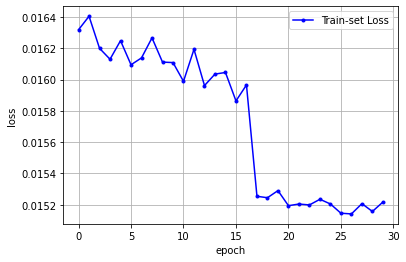

In [44]:
# x_len = numpy.arange(len(y_loss))
x_len = list(range(len(e.history['loss'])))
y_loss = e.history['loss']
# plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# 추가 loss, accuracy 추출 (loss는 mse mae 등으로 평가 할 수 있게 코드 추가해도 좋음)

In [ ]:
# LOSS ACCURACY MSE 등의 확인 가능

In [ ]:
# x_len = numpy.arange(len(y_loss))
x_len = list(range(len(e.history['accuracy'])))
y_loss = e.history['accuracy']
# plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='red', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()